In [0]:
# conditional generative adversarial network
# this version uses the MNIST dataset

In [2]:
# mount drive to access csv files

from google.colab import drive
drive.mount('./mnist_data')

Drive already mounted at ./mnist_data; to attempt to forcibly remount, call drive.mount("./mnist_data", force_remount=True).


In [0]:
# conventional PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [4]:
# GPU

#torch.cuda.is_available()
#torch.cuda.get_device_name(0)

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [0]:
import random
import pandas

In [0]:
import numpy
import matplotlib.pyplot as plt

In [7]:
# function to generate uniform random data
# size parameter is length of tensor

def generate_random(size):
    #return torch.rand(size)
    return torch.randn(size)

generate_random(5)

tensor([ 0.6497, -0.7409, -0.4704, -1.8899,  0.1266])

In [0]:
# dataset class

class MnistDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        image_target = torch.zeros((1,10))
        image_target[0,label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, image_target
    
    def plot_image(self, index):
        arr = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
        pass
    
    pass


In [0]:
# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data

mnist_dataset = MnistDataset('mnist_data/My Drive/Colab Notebooks/gan/mnist_data/mnist_train.csv')

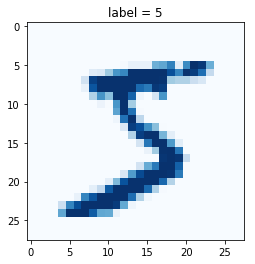

In [10]:
mnist_dataset.plot_image(0)

In [0]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [0]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            
            View((1, 784+10)),
            
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.2),
            
            nn.LayerNorm(200),
            
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.00001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, image_tensor, label_tensor):
        # combine image and label
        inputs = torch.cat((image_tensor.view(1, 784), label_tensor),1)
        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, image_tensor, label_tensor, targets):
        # calculate the output of the network
        outputs = self.forward(image_tensor, label_tensor)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [13]:
%%time
# create Discriminator and test it

D = Discriminator()
D.to(device)

# train Discriminator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for label, image_data_tensor, label_tensor in mnist_dataset:
        
        # train discriminator on real data
        D.train(image_data_tensor.view(1, 1, 28, 28), label_tensor, torch.cuda.FloatTensor([1.0]).view(1,1))
        
        # train discriminator on false (random) data
        D.train(generate_random(784).view(1, 1, 28, 28), generate_random(10).view(1, 10), torch.cuda.FloatTensor([0.0]).view(1,1))
    
        pass
    
    pass


training epoch 1 of 1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
c

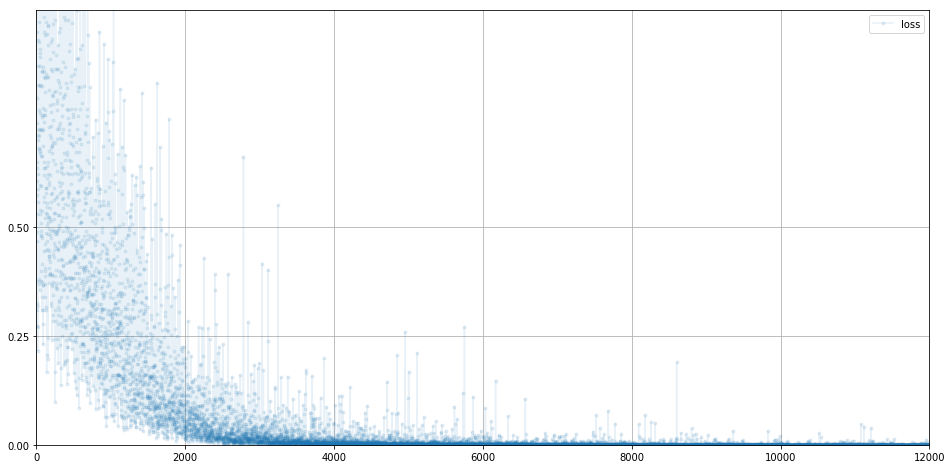

In [14]:
# plot discriminator error

D.plot_progress()

In [15]:
# manually check D can indeed discriminate between real and fake data

for i in range(4):
  print(D.forward(generate_random(784).view(1, 1, 28, 28),generate_random(10).view(1, 10)))
  pass

for i in range(4):
  idx = random.randint(0,10000)
  label, image_data_tensor, label_tensor = mnist_dataset[idx]
  print(D.forward(image_data_tensor.view(1, 1, 28, 28), label_tensor))
  pass


tensor([[0.0002]], grad_fn=<SigmoidBackward>)
tensor([[8.2421e-06]], grad_fn=<SigmoidBackward>)
tensor([[4.3376e-06]], grad_fn=<SigmoidBackward>)
tensor([[7.5361e-05]], grad_fn=<SigmoidBackward>)
tensor([[1.0000]], grad_fn=<SigmoidBackward>)
tensor([[1.0000]], grad_fn=<SigmoidBackward>)
tensor([[1.0000]], grad_fn=<SigmoidBackward>)
tensor([[1.0000]], grad_fn=<SigmoidBackward>)


In [0]:
# generator class
# this one uses only fully connected (nn.Linear) layers

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View((1,100+10)),
            
            nn.Linear(100+10, 500),
            nn.LeakyReLU(0.2),
            
            nn.LayerNorm(500),
            
            nn.Linear(500, 784),
            nn.Sigmoid(),
            
            View((1,1,28,28))
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using Adam for better gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.00001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, noise_tensor, label_tensor):
        # combine image and label
        inputs = torch.cat((noise_tensor, label_tensor),1)
        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, noise_tensor, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(noise_tensor, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self, label):
        label_tensor = torch.zeros((1,10))
        label_tensor[0,label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random(100).view(1,100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
      
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 10.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

torch.Size([1, 1, 28, 28])


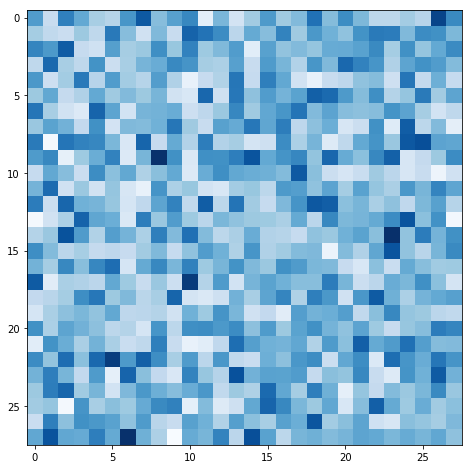

In [35]:
# scratch

G = Generator()

label_tensor = torch.zeros((1,10))
label_tensor[0,random.randint(0,9)] = 1.0

print(G(generate_random(100).view(1, 100), label_tensor).shape)

plt.figure(figsize = (16,8))
plt.imshow(G.forward(generate_random(100).view(1,100), label_tensor).view(28,28).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')

In [36]:
# create Discriminator and Generator

D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): View()
    (1): Linear(in_features=110, out_features=500, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): LayerNorm(torch.Size([500]), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
    (6): View()
  )
  (error_function): BCELoss()
)

In [82]:
%%time
# train Discriminator and Generator

epochs = 6

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # disturbance
        #d = numpy.exp(-numpy.square(D.counter/10000))
        #d = 0.1
      
        # train discriminator on real data
        D.train(image_data_tensor.view(1, 1, 28, 28), target_tensor, torch.cuda.FloatTensor([1.0]).view(1,1))

        # train discriminator on false
        # use detach() so only D is updated, not G
        # label softening doesn't apply to 0 labels
        D.train(G.forward(generate_random(100).view(1,100), target_tensor).detach(), target_tensor, torch.cuda.FloatTensor([0.0]).view(1,1))
        
        # train generator
        G.train(D, generate_random(100).view(1,100), target_tensor, torch.cuda.FloatTensor([1.0]).view(1,1))
        
        pass
    
    pass


training epoch 1 of 6
counter =  2170000
counter =  2180000
counter =  2190000
counter =  2200000
counter =  2210000
counter =  2220000
counter =  2230000
counter =  2240000
counter =  2250000
counter =  2260000
counter =  2270000
counter =  2280000
training epoch 2 of 6
counter =  2290000
counter =  2300000
counter =  2310000
counter =  2320000
counter =  2330000
counter =  2340000
counter =  2350000
counter =  2360000
counter =  2370000
counter =  2380000
counter =  2390000
counter =  2400000
training epoch 3 of 6
counter =  2410000
counter =  2420000
counter =  2430000
counter =  2440000
counter =  2450000
counter =  2460000
counter =  2470000
counter =  2480000
counter =  2490000
counter =  2500000
counter =  2510000
counter =  2520000
training epoch 4 of 6
counter =  2530000
counter =  2540000
counter =  2550000
counter =  2560000
counter =  2570000
counter =  2580000
counter =  2590000
counter =  2600000
counter =  2610000
counter =  2620000
counter =  2630000
counter =  2640000


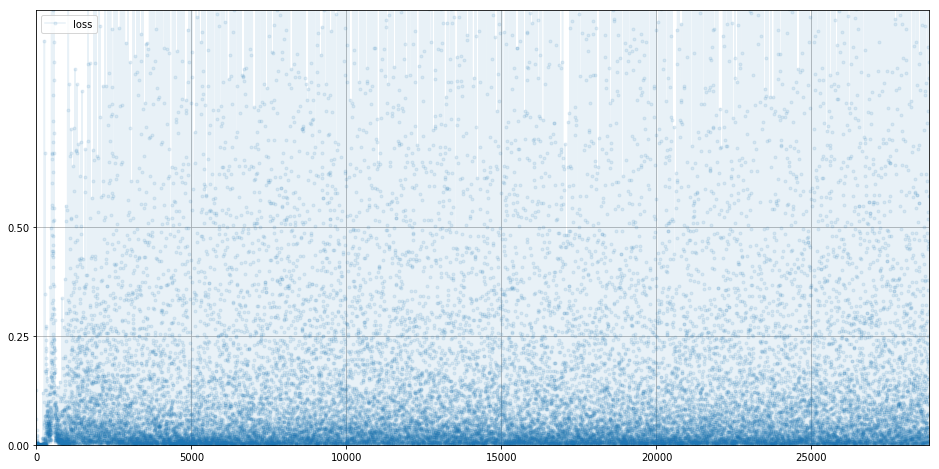

In [83]:
# plot discriminator error

D.plot_progress()

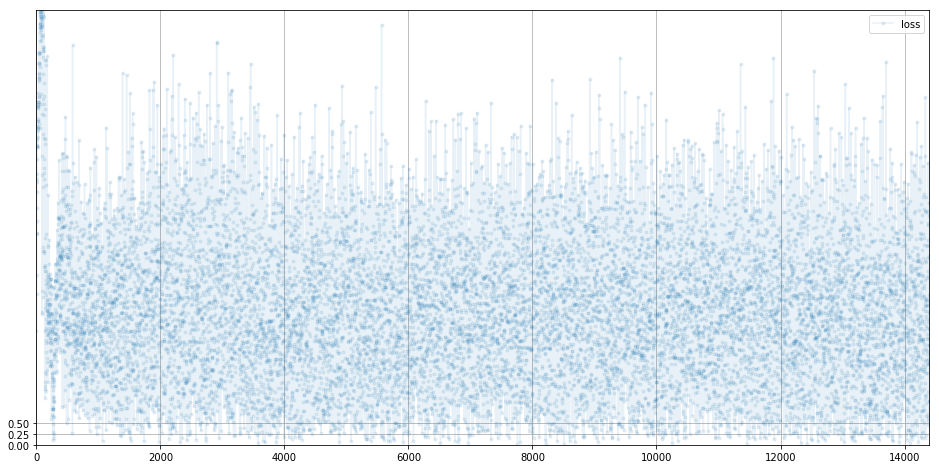

In [84]:
# plot generator error

G.plot_progress()

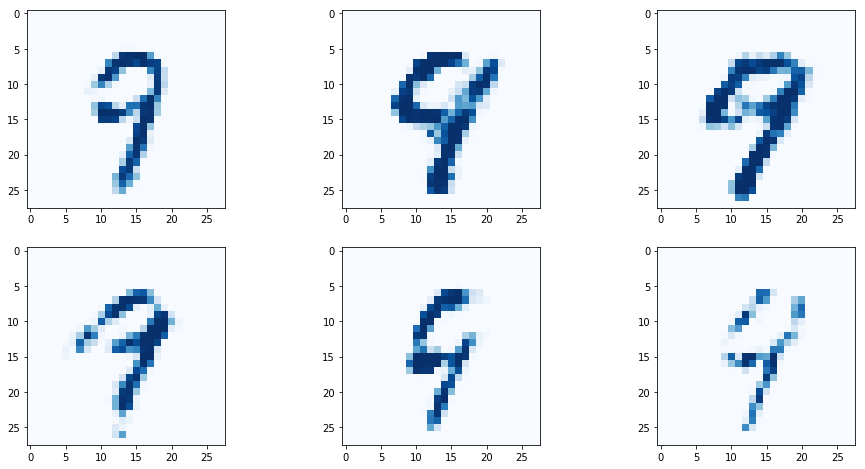

In [102]:
# show generator outputs as they evolve

G.plot_images(9)